In [66]:
from distutils.command.build import build
from multiprocessing.sharedctypes import Value
from joblib.logger import Logger
from main import parser
from copy import deepcopy
import os
import types
import pickle

import torch

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import evals
from mpvae import VAE, compute_loss
from data import load_data, load_data_masked
from utils import search_files, build_path
from logger import Logger
from fairsoft_trial import IMPLEMENTED_METHODS
from fairsoft_train_postprocess import calibrate_p, sigmoid

In [71]:
def extract_probs(dataset, reg_norm, model, return_only_target=True, target_fair_label=0, fair_coeff=1, seed=1):
    
    model_path = f'./new_fair_through_distance/model/{dataset}/probability/'

    model_file = os.path.join(
        model_path, f'unfair', f'unfair_vae_prior-500.00_{seed:04d}.pkl')
    
    results = pickle.load(open(model_file, 'rb'))
    results = results['valid']
    is_target = np.concatenate(results['is_target_label'])
    sensitive = np.concatenate(results['sensitive_idx'])
    is_target = np.concatenate(results['is_target_label'])
    # print(is_target.shape)
    labels = results['y_reals']
    preds = results['y_probs']    
    
    threshold_path = f'./fair_through_postprocess/model/{dataset}/'

    if model in ['indication', 'elementwise', 'constant']:
        threshold_file = os.path.join(
                threshold_path, f'baseline_{target_fair_label}', f'threshold-{model}-{reg_norm}_reg-{fair_coeff:.2f}_{seed:-04d}.pkl')
    elif 'jaccard' in model:
         threshold_file = os.path.join(
                threshold_path, f'jaccard_{target_fair_label}',  f'threshold-{model}-{reg_norm}_reg-{fair_coeff:.2f}_{seed:-04d}.pkl')

    threshold = pickle.load(open(threshold_file, 'rb'))
    threshold = sigmoid(threshold)
    
    cal_prob = calibrate_p(
        np.expand_dims(preds, -1), threshold)
    cal_prob = cal_prob.swapaxes(1, 2)[sensitive]
    
    if return_only_target:
        cal_prob = cal_prob[is_target]
        sensitive = sensitive[is_target]
        
    return cal_prob, sensitive

In [72]:
probs, sen_idx = extract_probs('adult', 'l2', 'indication')
n_labels = probs.shape[1]
nrows = n_labels // 5 + 1 * n_labels % 5
nrows

5

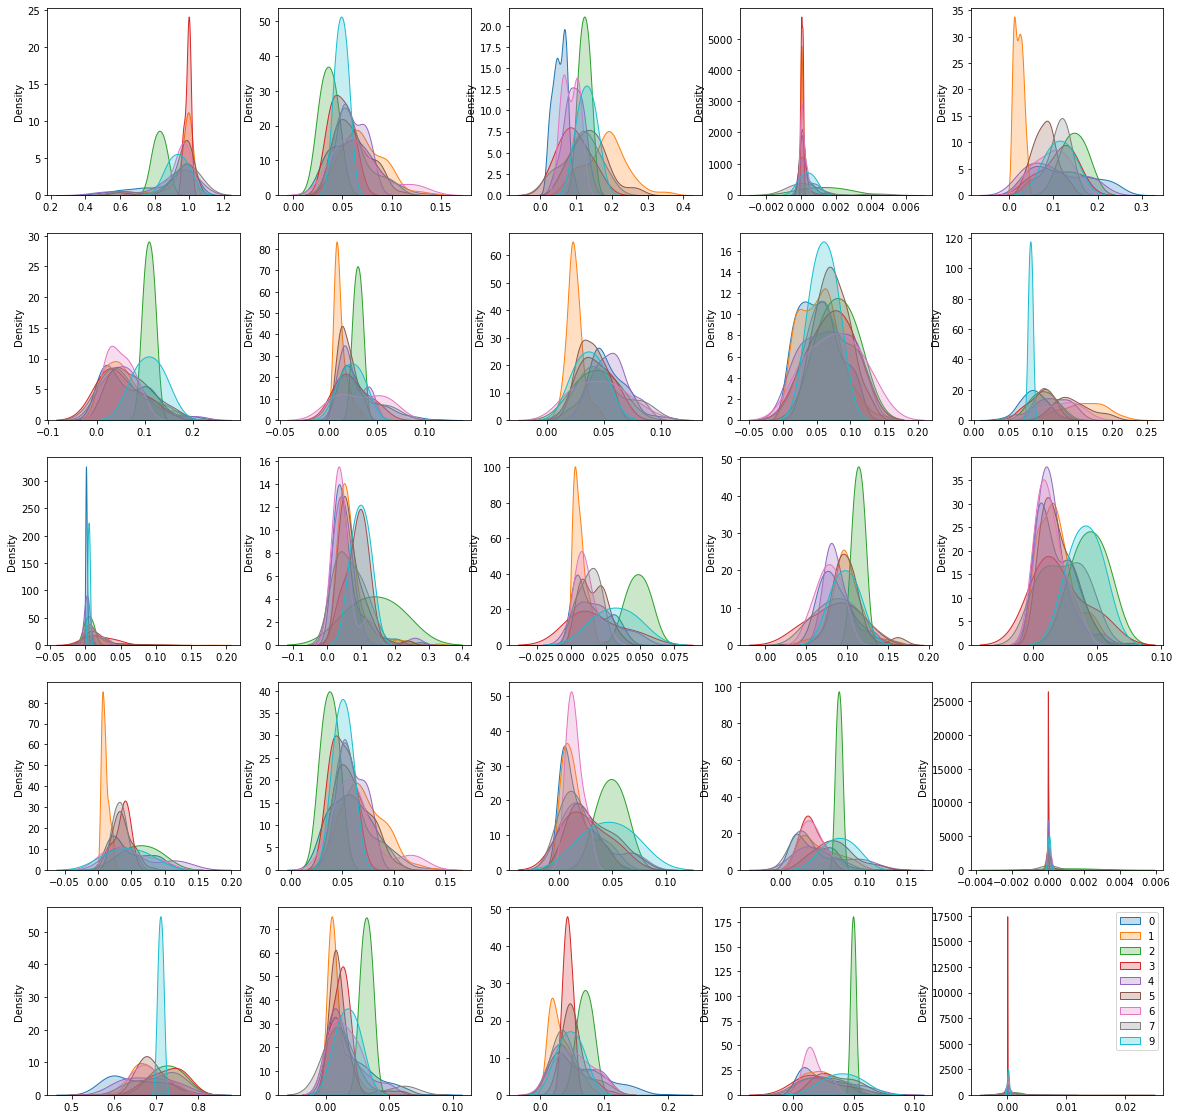

In [73]:
probs, sen_idx = extract_probs('adult', 'l1', 'constant')
n_labels = probs.shape[1]
ncols = 5
nrows = n_labels // ncols + 1 * n_labels % ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 4))

idxs = np.arange(len(probs))
for idx in range(sen_idx.shape[1]):
    idx_st = str(idx)
    sen_idxs = idxs[sen_idx[:, idx]]
    probs_sen = probs[sen_idxs]
    for i in np.arange(n_labels):
        ax = axes[i // ncols, i % ncols]
        sns.kdeplot(probs_sen[:, i], label=idx_st, ax=ax, fill=idx_st, warn_singular=False)

plt.legend()

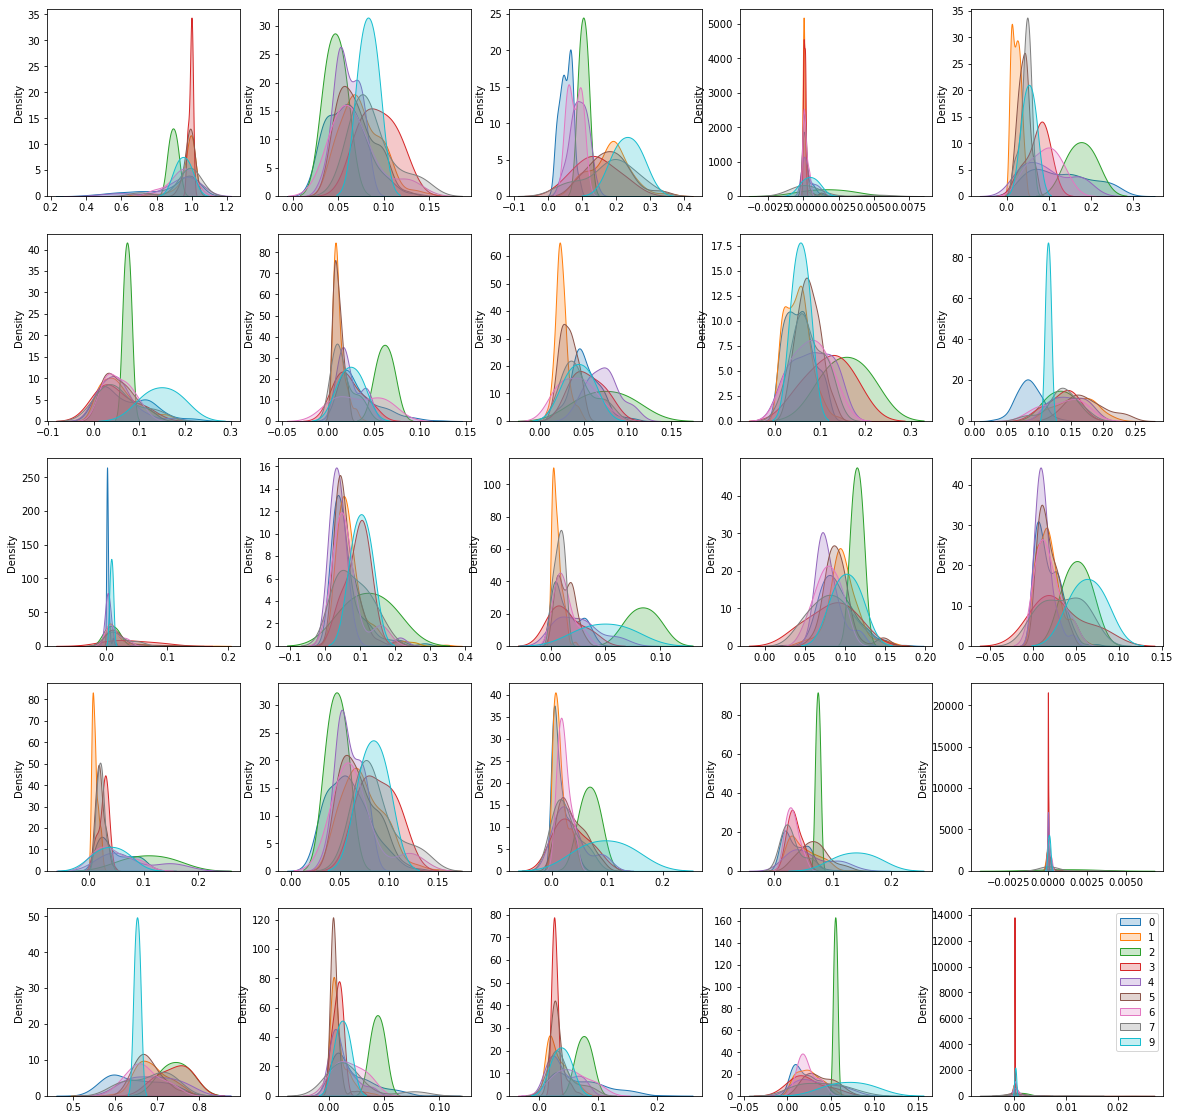

In [75]:
probs, sen_idx = extract_probs('adult', 'l1', 'indication')
n_labels = probs.shape[1]
ncols = 5
nrows = n_labels // ncols + 1 * n_labels % ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 4))

idxs = np.arange(len(probs))
for idx in range(sen_idx.shape[1]):
    idx_st = str(idx)
    sen_idxs = idxs[sen_idx[:, idx]]
    probs_sen = probs[sen_idxs]
    for i in np.arange(n_labels):
        ax = axes[i // ncols, i % ncols]
        sns.kdeplot(probs_sen[:, i], label=idx_st, ax=ax, fill=idx_st, warn_singular=False)

plt.legend()

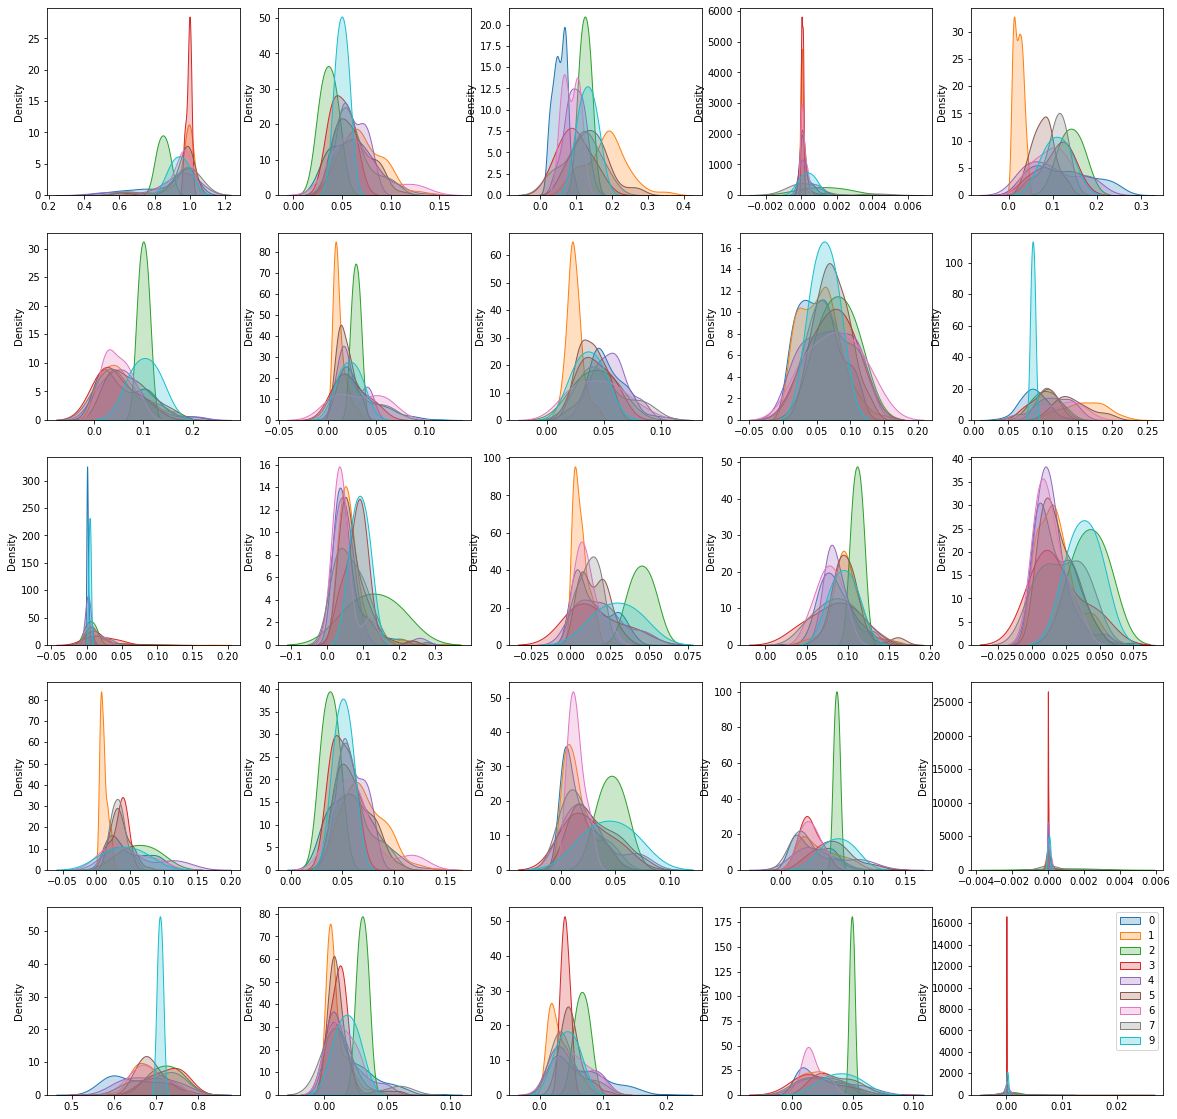

In [80]:
probs, sen_idx = extract_probs('adult', 'l1', 'jaccard_1.0')
n_labels = probs.shape[1]
ncols = 5
nrows = n_labels // ncols + 1 * n_labels % ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 4))

idxs = np.arange(len(probs))
for idx in range(sen_idx.shape[1]):
    idx_st = str(idx)
    sen_idxs = idxs[sen_idx[:, idx]]
    probs_sen = probs[sen_idxs]
    for i in np.arange(n_labels):
        ax = axes[i // ncols, i % ncols]
        sns.kdeplot(probs_sen[:, i], label=idx_st, ax=ax, fill=idx_st, warn_singular=False)

plt.legend()